# Spam Filtering

## The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged according being ham (legitimate) or spam.

In [3]:
import pandas as pd
import re
import string
import numpy as np
from sklearn.feature_extraction import _stop_words
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words
import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv("spam.csv",encoding = "'latin'")

In [5]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
data["text"] = data.v2
data["spam"] = data.v1

# Splitting data

In [7]:
from sklearn.model_selection import train_test_split
emails_train, emails_test, target_train, target_test = train_test_split(data.text,data.spam,test_size = 0.2) 

In [8]:
data.info

<bound method DataFrame.info of         v1                                                 v2 Unnamed: 2  \
0      ham  Go until jurong point, crazy.. Available only ...        NaN   
1      ham                      Ok lar... Joking wif u oni...        NaN   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3      ham  U dun say so early hor... U c already then say...        NaN   
4      ham  Nah I don't think he goes to usf, he lives aro...        NaN   
...    ...                                                ...        ...   
5567  spam  This is the 2nd time we have tried 2 contact u...        NaN   
5568   ham              Will Ì_ b going to esplanade fr home?        NaN   
5569   ham  Pity, * was in mood for that. So...any other s...        NaN   
5570   ham  The guy did some bitching but I acted like i'd...        NaN   
5571   ham                         Rofl. Its true to its name        NaN   

     Unnamed: 3 Unnamed: 4                             

In [9]:
emails_train.shape

(4457,)

# Preprocessing

In [10]:
def remove_hyperlink(word):
    return  re.sub(r"http\S+", "", word)

def to_lower(word):
    result = word.lower()
    return result

def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result

def remove_punctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

def remove_whitespace(word):
    result = word.strip()
    return result

def replace_newline(word):
    return word.replace('\n','')



def clean_up_pipeline(sentence):
    cleaning_utils = [remove_hyperlink,
                      replace_newline,
                      to_lower,
                      remove_number,
                      remove_punctuation,remove_whitespace]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence

x_train = [clean_up_pipeline(o) for o in emails_train]
x_test = [clean_up_pipeline(o) for o in emails_test]

x_train[0]

'wait  ltgt  min'

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(target_train.values)
test_y = le.transform(target_test.values)

In [12]:
train_y

array([0, 0, 0, ..., 0, 0, 0])

# Tokenize

In [13]:
## some config values 
embed_size = 100 # how big is each word vector
max_feature = 50000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 2000 # max number of words in a question to use

In [14]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=max_feature)

tokenizer.fit_on_texts(x_train)

x_train_features = np.array(tokenizer.texts_to_sequences(x_train))
x_test_features = np.array(tokenizer.texts_to_sequences(x_test))

x_train_features[0]

[202, 51, 265]

# Padding

In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train_features = pad_sequences(x_train_features,maxlen=max_len)
x_test_features = pad_sequences(x_test_features,maxlen=max_len)
x_train_features[0]

array([  0,   0,   0, ..., 202,  51, 265])

# Model

In [19]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional
from keras.models import Model

In [20]:
# create the model
import tensorflow as tf
embedding_vecor_length = 32

model = tf.keras.Sequential()
model.add(Embedding(max_feature, embedding_vecor_length, input_length=max_len))
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 32)          1600000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49664     
 l)                                                              
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,651,745
Trainable params: 1,651,745
Non-trainable params: 0
______________________________________________

In [21]:
history = model.fit(x_train_features, train_y, batch_size=512, epochs=20, validation_data=(x_test_features, test_y))

Epoch 1/20
9/9 [==============================] - 729s 84s/step - loss: 0.6536 - accuracy: 0.8548 - val_loss: 0.5712 - val_accuracy: 0.8735
Epoch 2/20
9/9 [==============================] - 1035s 118s/step - loss: 0.4607 - accuracy: 0.8640 - val_loss: 0.3937 - val_accuracy: 0.8735
Epoch 3/20
9/9 [==============================] - 913s 102s/step - loss: 0.3944 - accuracy: 0.8640 - val_loss: 0.3649 - val_accuracy: 0.8735
Epoch 4/20
9/9 [==============================] - 991s 111s/step - loss: 0.3567 - accuracy: 0.8640 - val_loss: 0.3119 - val_accuracy: 0.8735
Epoch 5/20
9/9 [==============================] - 1083s 122s/step - loss: 0.2783 - accuracy: 0.8643 - val_loss: 0.2159 - val_accuracy: 0.8735
Epoch 6/20
9/9 [==============================] - 1139s 127s/step - loss: 0.1733 - accuracy: 0.9298 - val_loss: 0.1504 - val_accuracy: 0.9641
Epoch 7/20
9/9 [==============================] - 1226s 138s/step - loss: 0.1120 - accuracy: 0.9785 - val_loss: 0.1155 - val_accuracy: 0.9695
Epoch 8/20

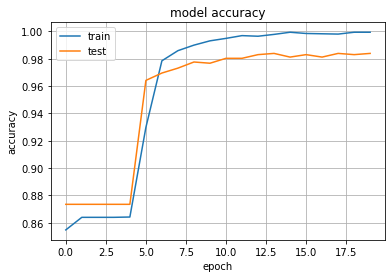

In [22]:
from  matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [27]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score

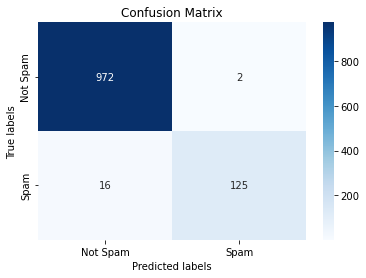

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt=''); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);

In [34]:
y_predict  = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]

35/35 [==============================] - 11s 284ms/step


In [35]:
cf_matrix =confusion_matrix(test_y,y_predict)

In [37]:
tn, fp, fn, tp = confusion_matrix(test_y,y_predict).ravel()

In [38]:
print("Precision: {:.2f}%".format(100 * precision_score(test_y, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(test_y, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(test_y,y_predict)))

Precision: 98.43%
Recall: 88.65%
F1 Score: 93.28%


In [39]:
f1_score(test_y,y_predict)

0.9328358208955224